<a href="https://colab.research.google.com/github/MeghanaVandana/Advanced_Mathematical_Statistics/blob/main/Project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, distance_matrix
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist


url_200 = "https://raw.githubusercontent.com/MeghanaVandana/Advanced_Mathematical_Statistics/main/Project6/200-labelled-points-in-r5e2.xlsx"
url_500 = "https://raw.githubusercontent.com/MeghanaVandana/Advanced_Mathematical_Statistics/main/Project6/500-labelled-points-in-r5e2.xlsx"


In [4]:
#Load the data
df200 = pd.read_excel(url_200, engine='openpyxl')
df500 = pd.read_excel(url_500, engine='openpyxl')

# Peek
print("200 dataset shape:", df200.shape)
print(df200.head())
print("500 dataset shape:", df500.shape)
print(df500.head())

# Expected column names: assume columns are named 'x', 'y', 'label' (if different, adapt below)
# Try to infer column names if not exact
def infer_xy_label(df):
    cols = df.columns.tolist()
    # common possibilities
    for xname in ['x','X','X1','x1','col1','V1']:
        if xname in cols:
            for yname in ['y','Y','Y1','x2','col2','V2']:
                if yname in cols:
                    for lname in ['label','Label','class','Class','y_label','target']:
                        if lname in cols:
                            return xname, yname, lname
    # fallback: pick first 3 columns
    return cols[0], cols[1], cols[2]

x200_col, y200_col, lab200_col = infer_xy_label(df200)
x500_col, y500_col, lab500_col = infer_xy_label(df500)

print("200 columns used:", x200_col, y200_col, lab200_col)
print("500 columns used:", x500_col, y500_col, lab500_col)

# Prepare numpy arrays
X200 = df200[[x200_col, y200_col]].values
y200 = df200[lab200_col].values
X500 = df500[[x500_col, y500_col]].values
y500 = df500[lab500_col].values

200 dataset shape: (200, 3)
          x         y  label
0 -0.597002  2.672630      1
1  2.896160  0.759178     -1
2  1.178250 -1.445410     -1
3 -1.383040 -0.095402      1
4 -2.176860 -0.841795      1
500 dataset shape: (500, 3)
          x        y  label
0 -1.604740 -2.36562      1
1 -1.140790 -2.71377      1
2  0.852063 -2.04262      1
3  2.436060 -1.53587      1
4  0.841200  2.21499      1
200 columns used: x y label
500 columns used: x y label


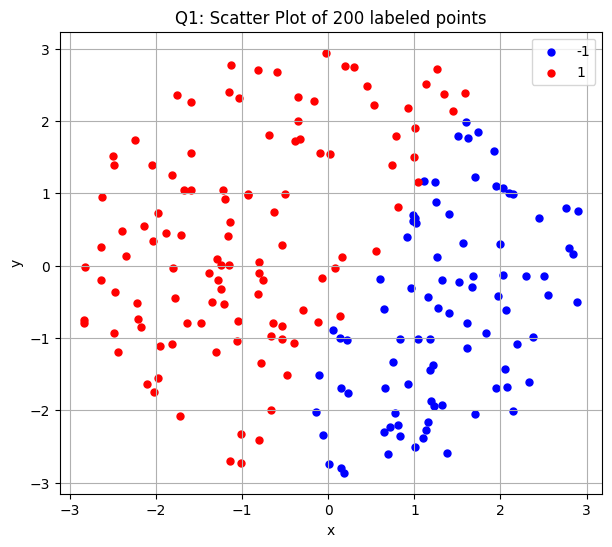

In [5]:
# Q1: Scatter plot of 200 points

plt.figure(figsize=(7,6))
plt.scatter(X200[y200==-1,0], X200[y200==-1,1], c='blue', label='-1', s=25)
plt.scatter(X200[y200==1,0], X200[y200==1,1], c='red', label='1', s=25)
plt.title("Q1: Scatter Plot of 200 labeled points")
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True)
plt.show()

In [8]:
#Visual separability check
svm_check = SVC(kernel='linear', C=1e6)
svm_check.fit(X200, y200)
train_acc = svm_check.score(X200, y200)
print("Q2: Linear SVM training accuracy on 200 points (high C):", train_acc)
if train_acc == 1.0:
    print("=> Perfect separation found (linearly separable).")
else:
    print("=> Not perfectly separable (overlap).")

Q2: Linear SVM training accuracy on 200 points (high C): 1.0
=> Perfect separation found (linearly separable).


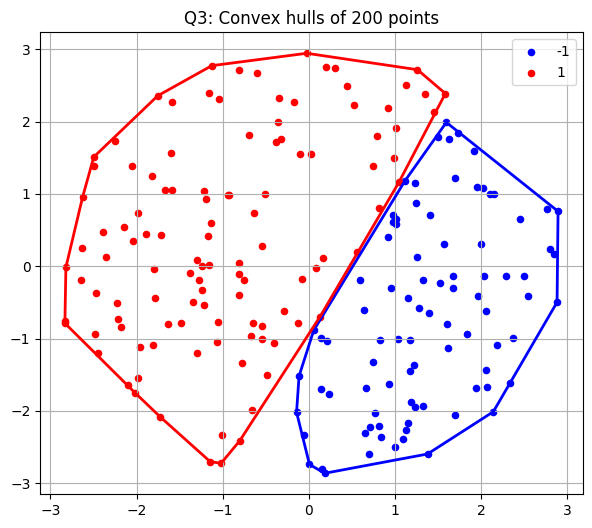

Q3: Quick bounding-box disjoint estimate: False


In [9]:
#Convex hulls for 200 points and plot

plt.figure(figsize=(7,6))
plt.scatter(X200[y200==-1,0], X200[y200==-1,1], c='blue', label='-1', s=20)
plt.scatter(X200[y200==1,0], X200[y200==1,1], c='red', label='1', s=20)

# compute convex hulls
def plot_convex_hull(points, color):
    if len(points) >= 3:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex,0], points[simplex,1], color=color, linewidth=2)
        return hull
    return None

hull_neg = plot_convex_hull(X200[y200==-1], 'blue')
hull_pos = plot_convex_hull(X200[y200==1], 'red')

plt.title("Q3: Convex hulls of 200 points")
plt.legend(); plt.grid(True)
plt.show()

# Check if hulls intersect by checking pairwise segment intersections or faster: check if any hull vertex of one is inside other hull via linear programming.
def hulls_disjoint(hullA_pts, hullB_pts):
    # simple approximate check: if any point of A is inside convex hull of B or vice versa -> not disjoint
    # We can use qhull: use ConvexHull and check via linear programming is complex; simple bounding-box quick check first
    minAx, maxAx = hullA_pts[:,0].min(), hullA_pts[:,0].max()
    minAy, maxAy = hullA_pts[:,1].min(), hullA_pts[:,1].max()
    minBx, maxBx = hullB_pts[:,0].min(), hullB_pts[:,0].max()
    minBy, maxBy = hullB_pts[:,1].min(), hullB_pts[:,1].max()
    if (maxAx < minBx) or (maxBx < minAx) or (maxAy < minBy) or (maxBy < minAy):
        return True
    # fallback: just say unknown for complex exact test
    return False

if (hull_neg is not None) and (hull_pos is not None):
    disjoint_est = hulls_disjoint(X200[y200==-1], X200[y200==1])
    print("Q3: Quick bounding-box disjoint estimate:", disjoint_est)
else:
    print("Q3: Not enough points for both hulls to compute disjointness.")

In [12]:
#Minkowski hyperplane

from scipy.spatial.distance import cdist


ptsA = X200[y200==-1]
ptsB = X200[y200==1]

# Compute pairwise distances
D = cdist(ptsA, ptsB)

# Find closest pair
i, j = np.unravel_index(np.argmin(D), D.shape)
pA = ptsA[i]
pB = ptsB[j]

# Midpoint and normal vector
mid = (pA + pB) / 2
normal = pB - pA
normal = normal / np.linalg.norm(normal)

# Line equation for Minkowski hyperplane
xx = np.linspace(min(X200[:,0]) - 1, max(X200[:,0]) + 1, 300)

# handle vertical case
if abs(normal[1]) > 1e-12:
    yy = -(normal[0]/normal[1]) * (xx - mid[0]) + mid[1]
else:
    yy = np.full_like(xx, mid[1])  # vertical line

print("Minkowski normal vector:", normal)


Minkowski normal vector: [-0.969715   -0.24423925]


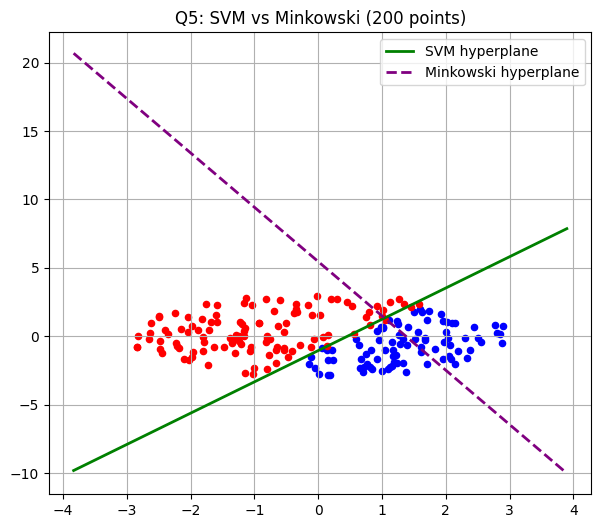

SVM normal vector: [-3.51969904  1.53948454]
SVM intercept: 1.6100862729172476


In [13]:
#SVM Maximum-Margin Hyperplane

svm200 = SVC(kernel='linear')
svm200.fit(X200, y200)

w = svm200.coef_[0]
b = svm200.intercept_[0]

xx_svm = np.linspace(min(X200[:,0]) - 1, max(X200[:,0]) + 1, 300)
yy_svm = -(w[0]/w[1]) * xx_svm - b/w[1]

plt.figure(figsize=(7,6))
plt.scatter(X200[y200==-1,0], X200[y200==-1,1], c='blue', s=20)
plt.scatter(X200[y200==1,0], X200[y200==1,1], c='red', s=20)

plt.plot(xx_svm, yy_svm, 'g-', linewidth=2, label='SVM hyperplane')
plt.plot(xx, yy, 'purple', linestyle='--', linewidth=2, label='Minkowski hyperplane')

plt.legend()
plt.title("Q5: SVM vs Minkowski (200 points)")
plt.grid(True)
plt.show()

print("SVM normal vector:", w)
print("SVM intercept:", b)


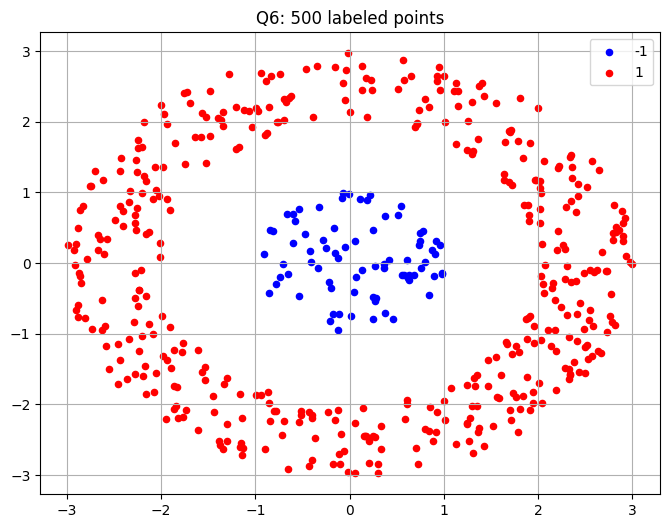

In [11]:
#Plot 500 labelled points

plt.figure(figsize=(8,6))
plt.scatter(X500[y500==-1,0], X500[y500==-1,1], c='blue', s=20, label='-1')
plt.scatter(X500[y500==1,0], X500[y500==1,1], c='red', s=20, label='1')
plt.title("Q6: 500 labeled points"); plt.legend(); plt.grid(True); plt.show()


In [15]:
# Option A: Fast exact-ish linear classifier (LinearSVC)
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# X500, y500 are assumed already loaded numpy arrays (shape (n,2), labels ±1)
# If labels are {0,1}, convert them back to {-1,1} or leave as is for LinearSVC.

pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(C=100.0,           # try 100 instead of 1e6; increase if needed
              loss='squared_hinge',
              penalty='l2',
              dual=False,
              max_iter=5000,
              tol=1e-4,
              random_state=42)
)

pipeline.fit(X500, y500)
train_acc = pipeline.score(X500, y500)
print("LinearSVC training accuracy:", train_acc)

# Extract weight vector (w) and intercept (b) from the trained LinearSVC
svc = pipeline.named_steps['linearsvc']
w = svc.coef_[0]
b = svc.intercept_[0]
print("w:", w, "b:", b)



LinearSVC training accuracy: 0.846
w: [ 0.00124513 -0.03629751] b: 0.6919930804508116


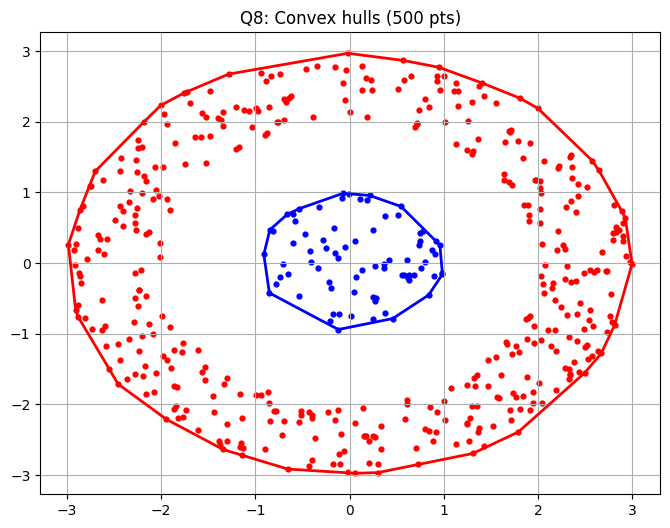

In [16]:
#Convex hulls for 500 points

plt.figure(figsize=(8,6))
plt.scatter(X500[y500==-1,0], X500[y500==-1,1], c='blue', s=12)
plt.scatter(X500[y500==1,0], X500[y500==1,1], c='red', s=12)
hull500_neg = plot_convex_hull(X500[y500==-1], 'blue')
hull500_pos = plot_convex_hull(X500[y500==1], 'red')
plt.title("Q8: Convex hulls (500 pts)"); plt.grid(True); plt.show()

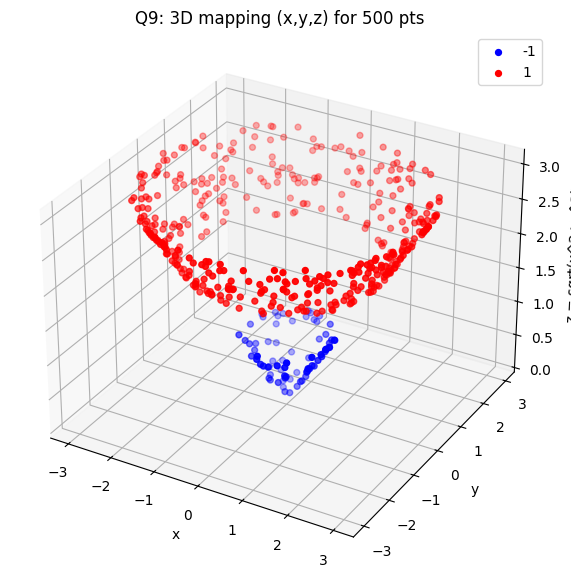

In [17]:
#Lift 500 points to 3D: z = sqrt(x^2 + y^2) and plot

x = X500[:,0]; y_ = X500[:,1]; z = np.sqrt(x**2 + y_**2)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[y500==-1], y_[y500==-1], z[y500==-1], c='blue', s=18, label='-1')
ax.scatter(x[y500==1], y_[y500==1], z[y500==1], c='red', s=18, label='1')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z = sqrt(x^2+y^2)')
plt.title("Q9: 3D mapping (x,y,z) for 500 pts"); plt.legend(); plt.show()


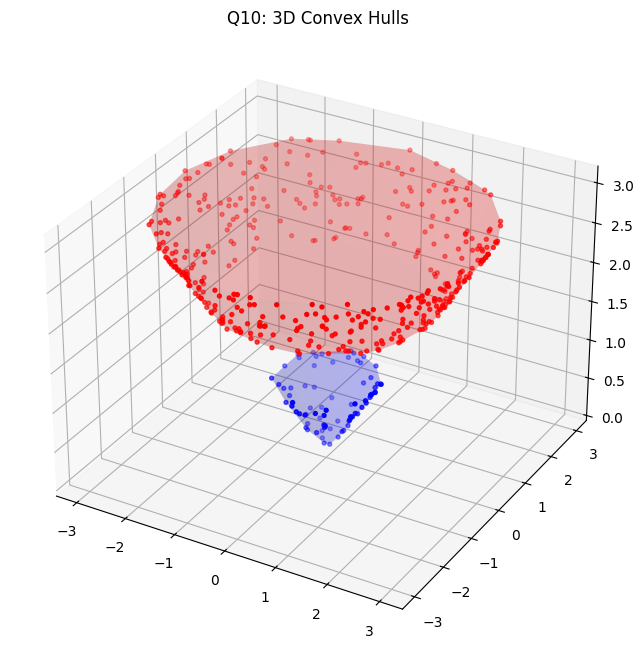

In [18]:
#3D convex hulls — caution: 3D hull requires >=4 non-coplanar points
pts_neg3 = np.column_stack([x[y500==-1], y_[y500==-1], z[y500==-1]])
pts_pos3 = np.column_stack([x[y500==1], y_[y500==1], z[y500==1]])

# If each class has >=4 points, compute 3D hulls
do3d = (pts_neg3.shape[0] >= 4) and (pts_pos3.shape[0] >= 4)
if do3d:
    hull3_neg = ConvexHull(pts_neg3)
    hull3_pos = ConvexHull(pts_pos3)

    # 3D scatter and hull facets (simple visualization)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts_neg3[:,0], pts_neg3[:,1], pts_neg3[:,2], c='blue', s=8)
    ax.scatter(pts_pos3[:,0], pts_pos3[:,1], pts_pos3[:,2], c='red', s=8)

    # plot hull facets (negative)
    for simplex in hull3_neg.simplices:
        tri = pts_neg3[simplex]
        ax.plot_trisurf(tri[:,0], tri[:,1], tri[:,2], color='blue', alpha=0.15, linewidth=0)

    for simplex in hull3_pos.simplices:
        tri = pts_pos3[simplex]
        ax.plot_trisurf(tri[:,0], tri[:,1], tri[:,2], color='red', alpha=0.15, linewidth=0)

    plt.title("Q10: 3D Convex Hulls")
    plt.show()
else:
    print("Q10: Not enough points to compute 3D convex hulls for one or both classes.")


Q11: Minkowski 3D closest pair: [0.958231   0.251801   0.99076253] [1.90756    0.601731   2.00021633] normal: [0.66422814 0.24483962 0.70629636]


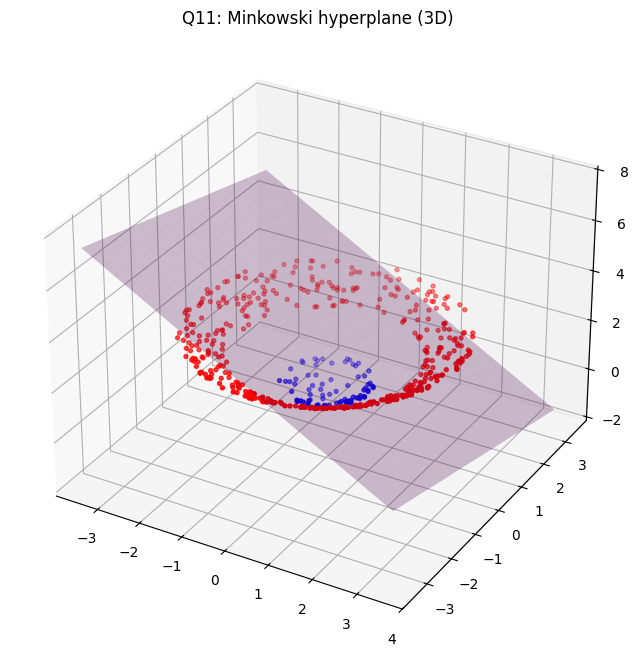

Q11: SVM 3D normal: [ 0.0056581  -0.00208174  1.96768003] b: -2.9538581703298536


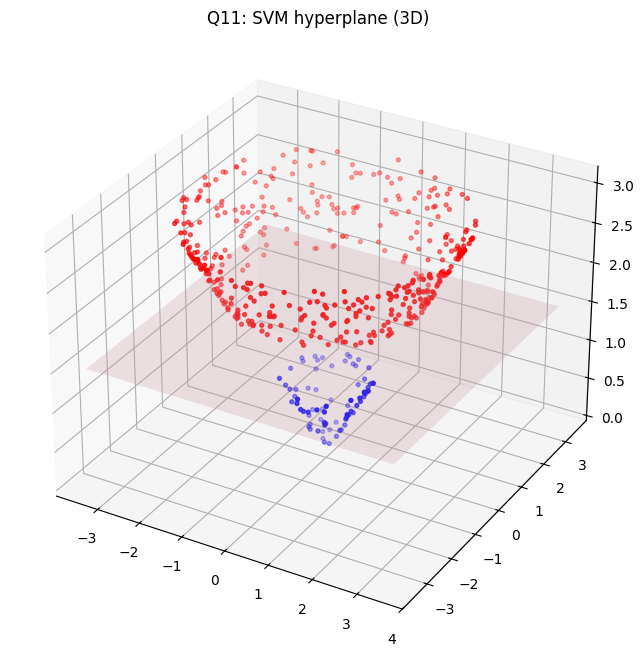

In [20]:
#Minkowski hyperplane and SVM hyperplane in 3D for lifted data
if do3d:
    # Minkowski: find closest vertices between 3D hulls (use hull vertices)
    vertsA = pts_neg3[hull3_neg.vertices]
    vertsB = pts_pos3[hull3_pos.vertices]
    D3 = cdist(vertsA, vertsB)
    i3, j3 = np.unravel_index(np.argmin(D3), D3.shape)
    pA3 = vertsA[i3]; pB3 = vertsB[j3]
    mid3 = (pA3 + pB3)/2
    normal3 = pB3 - pA3
    normal3 = normal3 / np.linalg.norm(normal3)
    print("Q11: Minkowski 3D closest pair:", pA3, pB3, "normal:", normal3)

    # Plot Minkowski plane
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts_neg3[:,0], pts_neg3[:,1], pts_neg3[:,2], c='blue', s=8)
    ax.scatter(pts_pos3[:,0], pts_pos3[:,1], pts_pos3[:,2], c='red', s=8)

    # create meshgrid for plane
    xx = np.linspace(x.min()-0.5, x.max()+0.5, 20)
    yy = np.linspace(y_.min()-0.5, y_.max()+0.5, 20)
    XX, YY = np.meshgrid(xx, yy)
    # solve for Z from plane equation normal3 . (X - mid3) = 0 => normal3[0]*(X) + normal3[1]*(Y) + normal3[2]*Z + d = 0
    d3 = -normal3.dot(mid3)
    ZZ = (-normal3[0]*XX - normal3[1]*YY - d3) / (normal3[2] + 1e-12)

    ax.plot_surface(XX, YY, ZZ, alpha=0.25, color='purple')
    plt.title("Q11: Minkowski hyperplane (3D)")
    plt.show()

    # SVM in 3D (linear)
    # Fit SVM on (x,y,z)
    XYZ = np.column_stack([x,y_,z])
    svm3 = SVC(kernel='linear')
    svm3.fit(XYZ, y500)
    w3 = svm3.coef_[0]; b3 = svm3.intercept_[0]
    print("Q11: SVM 3D normal:", w3, "b:", b3)

    # SVM plane
    ZZ_svm = (-w3[0]*XX - w3[1]*YY - b3) / (w3[2] + 1e-12)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts_neg3[:,0], pts_neg3[:,1], pts_neg3[:,2], c='blue', s=8)
    ax.scatter(pts_pos3[:,0], pts_pos3[:,1], pts_pos3[:,2], c='red', s=8)
    ax.plot_surface(XX, YY, ZZ_svm, alpha=0.25, color='pink')
    plt.title("Q11: SVM hyperplane (3D)")
    plt.show()
else:
    print("Q11: SVM/Minkowski 3D computations skipped due to insufficient points.")
